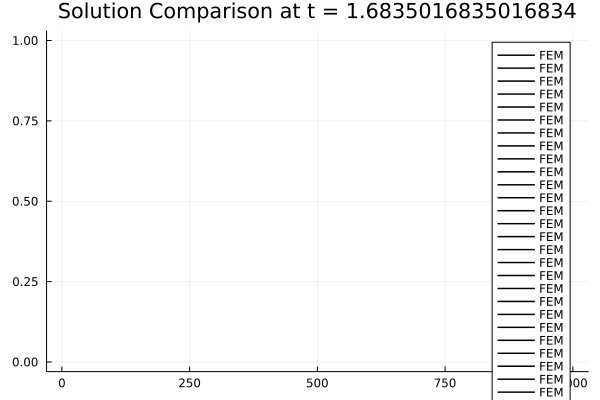

In [6]:
using LinearAlgebra
using Plots

# Basic parameters
nt = 2000    # Number of time steps
vs = 3000    # Wave velocity [m/s] 
ro0 = 2500    # Density [kg/m^3]
nx = 100    # Number of grid points  
isx = 500     # Source location [m] 
xmax = 1000.0  # Maximum length
eps = 0.5     # Stability limit
iplot = 20      # Snapshot frequency

dx = xmax / (nx - 1)           # calculate space increment
x = range(0, stop=nx - 1) * dx   # initialize space coordinates
x = transpose(x)
# println(length(x))
# println(x)
h = diff(vec(x) )                    # calculate the element sizes)
# println(h)

# parameters
ro = x * 0 .+ ro0
mu = x * 0 .+ ro .* vs .^ 2

# time step from stability criterion
dt = 0.5 * eps * dx / maximum(sqrt.(mu ./ ro))
# initialize time axis
t = range(dt, stop=nt * dt, length=nt)

# 
u = zeros(nx)
uold = zeros(nx)
unew = zeros(nx)

p = zeros(nx)
pold = zeros(nx)
pnew = zeros(nx)

# Mass matrix M_ij
M = zeros(nx, nx)
for i in 2:nx-1
    for j in 2:nx-1
        if j == i
            M[i, j] = (ro[i-1] * h[i-1] + ro[i] * h[i]) / 3
        elseif j == i + 1
            M[i, j] = ro[i] * h[i] / 6
        elseif j == i - 1
            M[i, j] = ro[i-1] * h[i-1] / 6
        else
            M[i, j] = 0
        end
    end
end

# Corner elements
M[1, 1] = ro[1] * h[1] / 3
M[nx, nx] = ro[nx] * h[nx-1] / 3

# Invert M
Minv = inv(M)

# heatmap(Minv, title="Mass Matrix M", color=:viridis, legend=false)

# Stiffness matrix Kij
K = zeros(nx, nx)
for i in 2:nx-1
    for j in 2:nx-1
        if j == i
            K[i, j] = mu[i-1] / h[i-1] + mu[i] / h[i]
        elseif j == i + 1
            K[i, j] = -mu[i] / h[i]
        elseif j == i - 1
            K[i, j] = -mu[i-1] / h[i-1]
        else
            K[i, j] = 0
        end
    end
end

# Corner elements
K[1, 1] = mu[1] / h[1]
K[nx, nx] = mu[nx-1] / h[nx-1]

# heatmap(K, title="Stiffness Matrix K", color=:viridis, legend=false)

u_time = zeros(nt, nx)
for it in 1:nt
    unew = (dt^2) * Minv * (K * u) + 2*u - uold                         
    uold, u = u, unew

    u_time[it, :] = u
    if it % 10 == 0
        IJulia.clear_output(true)
        plt = plot(x, u, color=:black, linewidth=1.5, label="FEM")
        plot!(x, p, color=:red, linewidth=1.5, label="FDM")
        title!("Solution Comparison at t = $(it*dt)")
        display(plt)
    end
end




In [1]:
using Plots

max_u = maximum(u_time)
min_u = minimum(u_time)

anim = @animate for it = 1:nt
    plot((0:nx-1) .* (dx), u_time[it, :], legend=true, title="time: $(it*dt) s", label="wave", ylims=(min_u, max_u), xlabel="x (m)", ylabel="Amplitude (m)")
end

gif(anim, "elastic_wave-1 fem.gif", fps=20)

LoadError: UndefVarError: `u_time` not defined